Linear R²: 0.6482971271990439
Linear RMSE: 15.172232249592714
Linear Coefficients: [ 0.22798448  4.99892955  8.15272159 -0.09368021  0.4779837  -0.06774671
  0.16377114 -0.01156914]
Ridge R²: 0.6482971771199089
Ridge RMSE: 15.172231172815916
Lasso R²: 0.6484038596278827
Lasso RMSE: 15.169929891264674


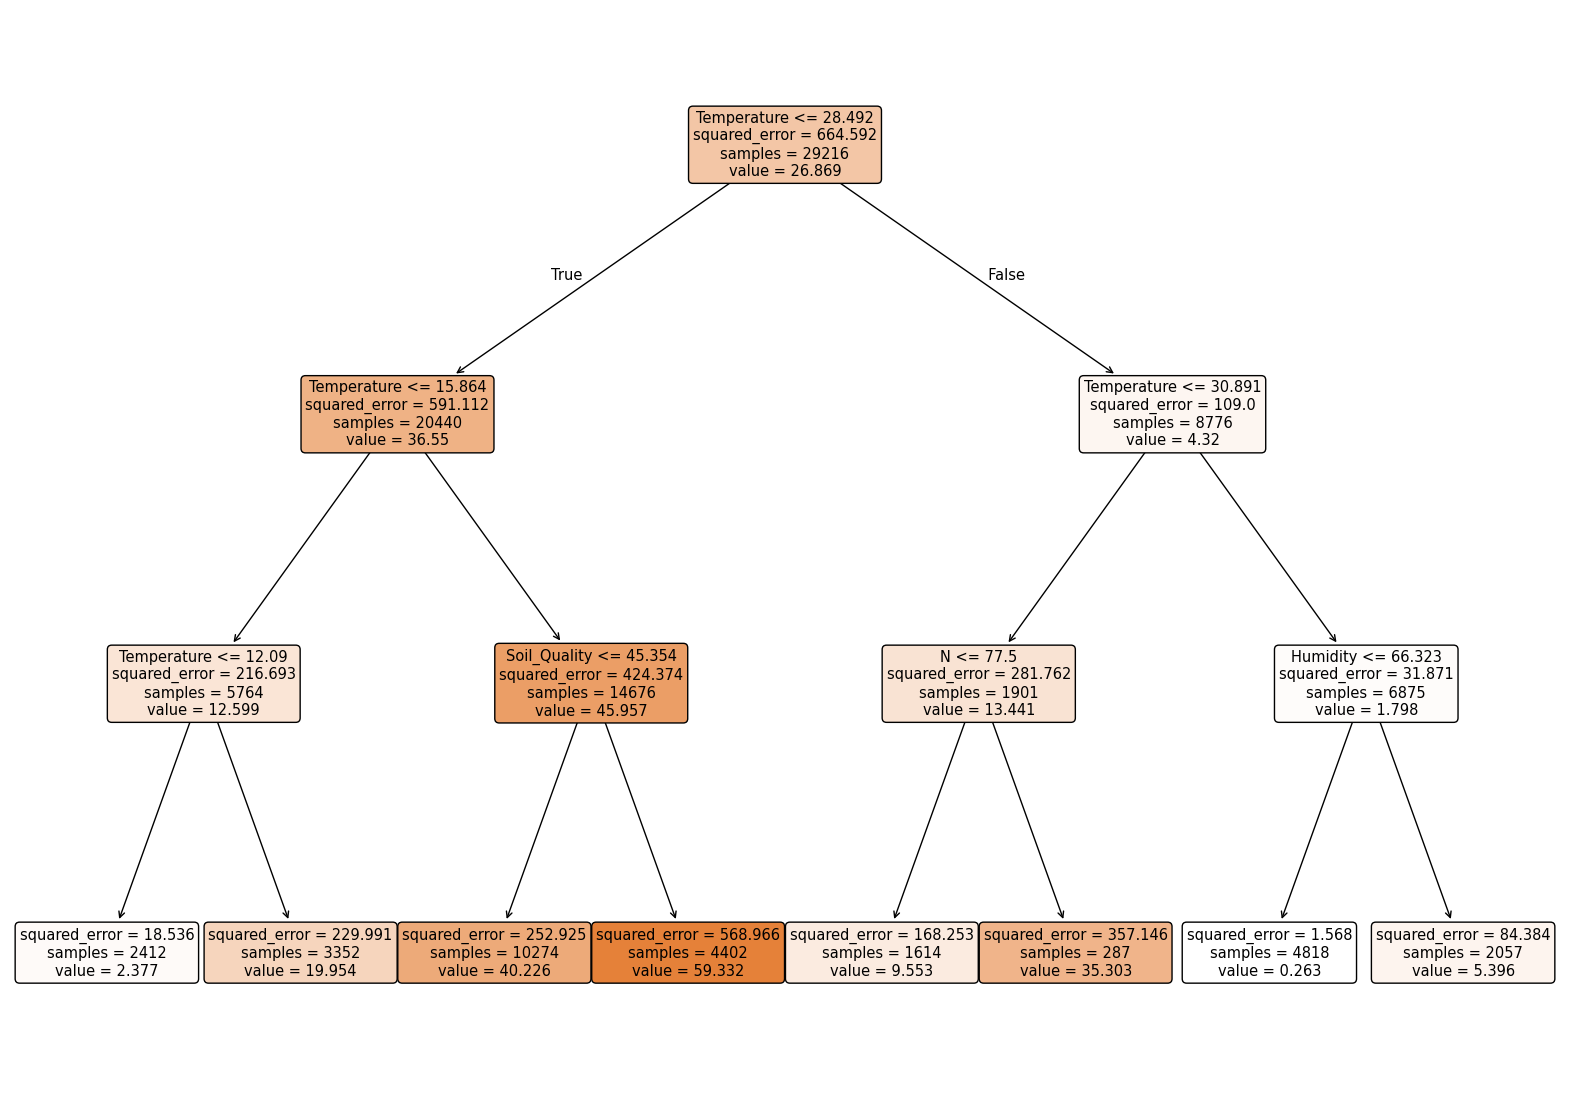

Decision Tree R²: 0.6608007758773188
Decision Tree RMSE: 14.900091976766182


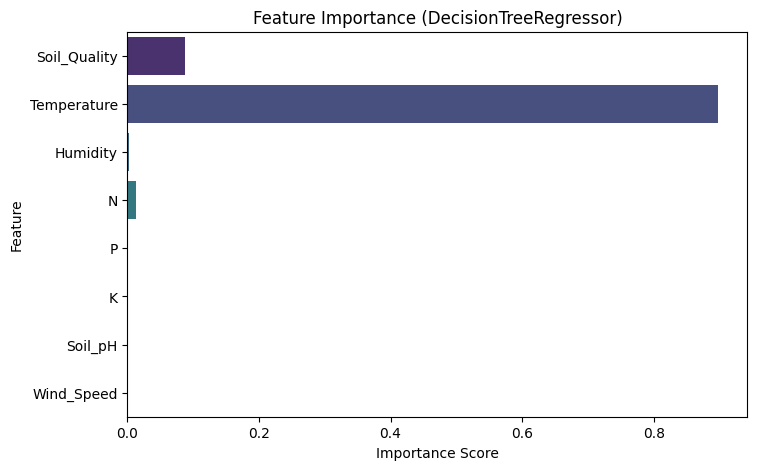

RandomForest R²: 0.9759266567447397
RandomForest RMSE: 3.9694444475691437


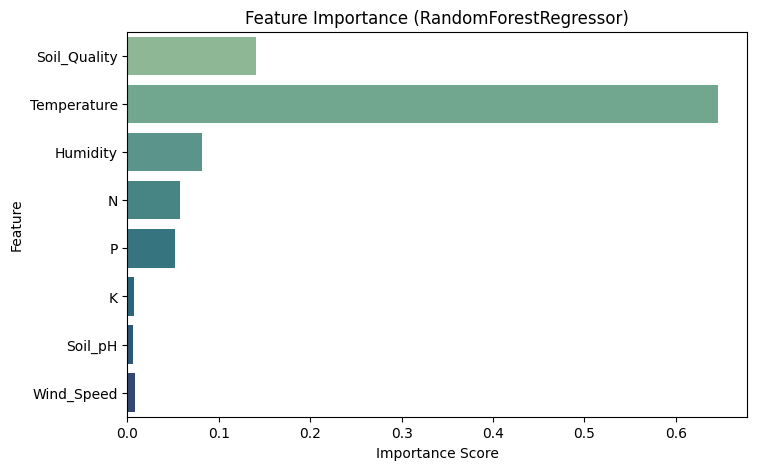

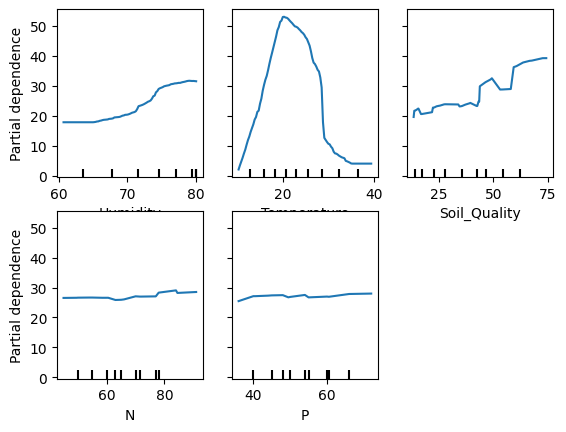

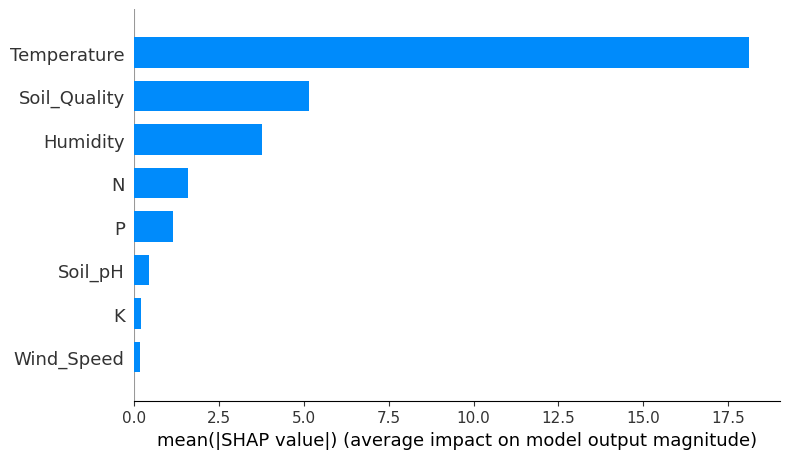

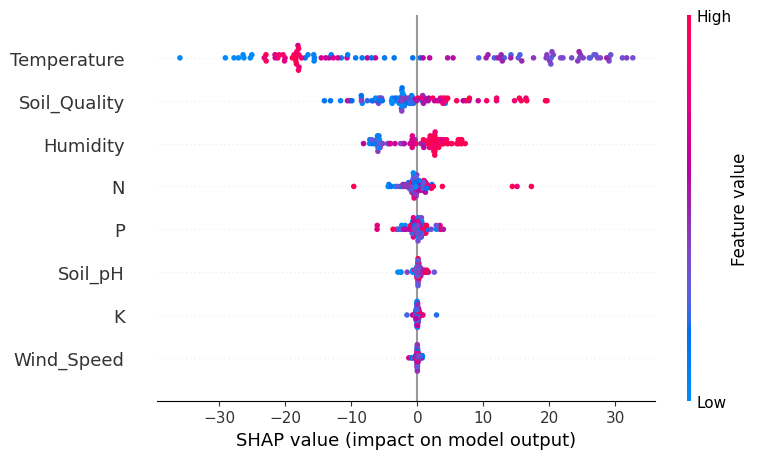

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_text
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import PartialDependenceDisplay
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
import shap
import os

warnings.filterwarnings("ignore")

# Make directory if it doesn’t exist
os.makedirs("plots", exist_ok=True)
os.makedirs("plots/rmplots", exist_ok=True)

ds = pd.read_csv("crop_yield_dataset.csv")
ds["Date"] = pd.to_datetime(ds["Date"])
ds["Year"] = ds["Date"].dt.year
ds["Month"] = ds["Date"].dt.month

crops = ["Tomato", "Wheat", "Corn", "Rice", "Barley", "Soybean", "Cotton", "Sugarcane", "Potato", "Sunflower"]

palette = sns.color_palette("tab10", n_colors=len(crops))

# ----------------------------------------------------------------------------
# Dataset Selection
# ----------------------------------------------------------------------------

# Select features (from EDA results)
X = ds[["Soil_Quality", "Temperature", "Humidity", "N", "P", "K", "Soil_pH", "Wind_Speed"]]
y = ds["Crop_Yield"]

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=36)

# ----------------------------------------------------------------------------
# Linear Regression
# ----------------------------------------------------------------------------

# Train regression
model = LinearRegression()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
print("Linear R²:", r2_score(y_test, y_pred)) # Measures how well the model explains variation in the data. Low R² means there are other factors not captured by the model (or a lot of randomness).
print("Linear RMSE:", np.sqrt(mean_squared_error(y_test, y_pred))) # Measures the average prediction error, in the same units as the target
print("Linear Coefficients:", model.coef_) # Each number shows the effect of a 1-unit increase in that feature, while keeping others constant.

#------------------------------------------------------------------------------
# Ridge Regression
# -----------------------------------------------------------------------------
# Linear regression + L2 penalty (shrinks coefficients).
# Good when you have multicollinearity.

ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)

print("Ridge R²:", r2_score(y_test, y_pred_ridge))
print("Ridge RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_ridge)))

# -----------------------------------------------------------------------------
# Lasso Regression
# -----------------------------------------------------------------------------
# Linear regression + L1 penalty (can shrink some coefficients all the way to 0).
# Good for feature selection — it automatically “drops” unimportant predictors.

lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)

print("Lasso R²:", r2_score(y_test, y_pred_lasso))
print("Lasso RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lasso)))

# ------------------------------------------------------------------------------
# DescisionTreeRegressor
# ------------------------------------------------------------------------------
# Splits the data into branches based on feature thresholds.

# Train Decision Tree
tree = DecisionTreeRegressor(max_depth=3, random_state=36)  # max_depth controls tree size
tree.fit(X_train, y_train)

# Predictions
y_pred = tree.predict(X_test)

# Plot Tree
plt.figure(figsize=(20, 14))
plot_tree(tree, feature_names=X.columns, filled=True, rounded=True)
plt.savefig("plots/rmplots/decisiontree_tree.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close()

print("Decision Tree R²:", r2_score(y_test, y_pred))
print("Decision Tree RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

# Feature importance values
importances = tree.feature_importances_
features = X.columns

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=importances, y=features, palette="viridis")
plt.title("Feature Importance (DecisionTreeRegressor)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.savefig("plots/rmplots/decisiontree_feature_importance.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close()

# Exporting data from Tree

# print("Features:", tree.tree_.feature)      # indices of features at each split
# print("Thresholds:", tree.tree_.threshold)  # split points
# print("Values:", tree.tree_.value)          # predicted mean at each node

# rules = export_text(tree, feature_names=list(X.columns))
# print(rules)

# ---------------------------------------------------------------------------------
# RandomForestRegressor
# ---------------------------------------------------------------------------------
# A combination of hundreds of Decision Trees, averaged out, typically resulting in less errors

# Train RandomForest
rf = RandomForestRegressor(n_estimators=100, max_depth=None, random_state=36)
rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)

print("RandomForest R²:", r2_score(y_test, y_pred))
print("RandomForest RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

#Plot
importances = rf.feature_importances_
features = X.columns

plt.figure(figsize=(8, 5))
sns.barplot(x=importances, y=features, palette="crest")
plt.title("Feature Importance (RandomForestRegressor)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.savefig("plots/rmplots/randomforest_feature_importance.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close()

# PDP -----------------------------------------------------------
# Partial Dependence Plots (PDPs) show how changing one feature (e.g., Humidity) affects the predicted yield, keeping other features constant.

PartialDependenceDisplay.from_estimator(rf, X, ["Humidity", "Temperature", "Soil_Quality", "N", "P",])
plt.savefig("plots/rmplots/randomforest_PDP.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close()

# SHAP ----------------------------------------------------------
# SHAP = SHapley Additive exPlanations It’s based on Shapley values from cooperative game theory.
# The idea: each feature is like a “player” in a game, and SHAP calculates how much each player (feature) contributed to the final outcome compared to a baseline

# Create an explainer for the model
explainer = shap.TreeExplainer(rf)
X_sample = X_test.sample(100, random_state=36) if len(X_test) > 100 else X_test
shap_values = explainer.shap_values(X_sample)

shap.initjs()
# Summary plot: global feature importance + direction
shap.summary_plot(shap_values, X_sample, plot_type="bar")
plt.savefig("plots/rmplots/shap_summary.png", dpi=300, bbox_inches="tight")
plt.close()

# Beeswarm plot: shows how features push predictions up or down
shap.summary_plot(shap_values, X_sample)
plt.savefig("plots/rmplots/shap_bar.png", dpi=300, bbox_inches="tight")
plt.close()

# Force plot: explanation for a single prediction
i = 0  # index of a row in your test set
shap_html = shap.force_plot(
    explainer.expected_value, shap_values[i], X_sample.iloc[i], matplotlib=False
)
shap.save_html("plots/rmplots/shap_force_plot.html", shap_html)

# --------------------------------------------------------------------------
# GBR
# --------------------------------------------------------------------------
# Very similar to RandomForest. Think of GBR as a more “focused” learner that tries to correct its own mistakes step by step.

# Initialize model
gbr = GradientBoostingRegressor(
    n_estimators=200,     # number of boosting stages (like trees)
    learning_rate=0.1,    # how much each tree contributes
    max_depth=5,          # depth of each tree
    random_state=36
)

# Train
gbr.fit(X_train, y_train)

# Predict
y_pred = gbr.predict(X_test)

# Evaluate
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"GradientBoosting R²: {r2:.3f}")
print(f"GradientBoosting RMSE: {rmse:.3f}")


importances = gbr.feature_importances_
features = X_train.columns

plt.barh(features, importances)
plt.xlabel("Feature Importance")
plt.title("GradientBoostingRegressor - Feature Importance")
plt.show()

# -------------------------------------------------------
# Model Comparison
# -------------------------------------------------------

models = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.01),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    results.append({"Model": name, "R²": r2, "RMSE": rmse})

results_df = pd.DataFrame(results)
print(results_df)
